# Auto SARIMA


## Imports


In [118]:
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm

## Data


In [119]:
# Carregar o conjunto de dados
df = pd.read_csv("../data/commerce_dataset_clean.csv", sep=";")

In [120]:
# Converter a coluna 'dtme' para datetime e definir como índice do DataFrame
df["dtme"] = pd.to_datetime(df["dtme"])
df.set_index("dtme", inplace=True)

In [121]:
# Agregar os totais de vendas por dia
sales_daily = df.groupby("dtme")["total"].sum()

# Visualizar as primeiras entradas da série agregada
# sales_daily.head()

# Calcular o índice no qual dividir os dados
split_index = int(len(sales_daily) * 0.5)

# Dividir os dados em conjuntos de treinamento e teste
train_data = sales_daily[:split_index]
test_data = sales_daily[split_index:]

## Model


In [122]:
# Seasonal - fit stepwise auto-ARIMA
SARIMA_model = pm.auto_arima(
    train_data,
    start_p=1,
    start_q=1,
    test="adf",
    max_p=3,
    max_q=3,
    m=12,  # 12 is the frequncy of the cycle
    start_P=0,
    seasonal=True,  # set to seasonal
    d=None,
    D=1,  # order of the seasonal differencing
    trace=False,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True,
)

# Print the summary of the model
print(SARIMA_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   44
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -276.374
Date:                            Wed, 28 Feb 2024   AIC                            558.749
Time:                                    02:22:19   BIC                            563.051
Sample:                                01-01-2019   HQIC                           560.151
                                     - 02-13-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8331      0.152     -5.488      0.000      -1.131      -0.536
ma.S.L12      -0.7557      0.497   

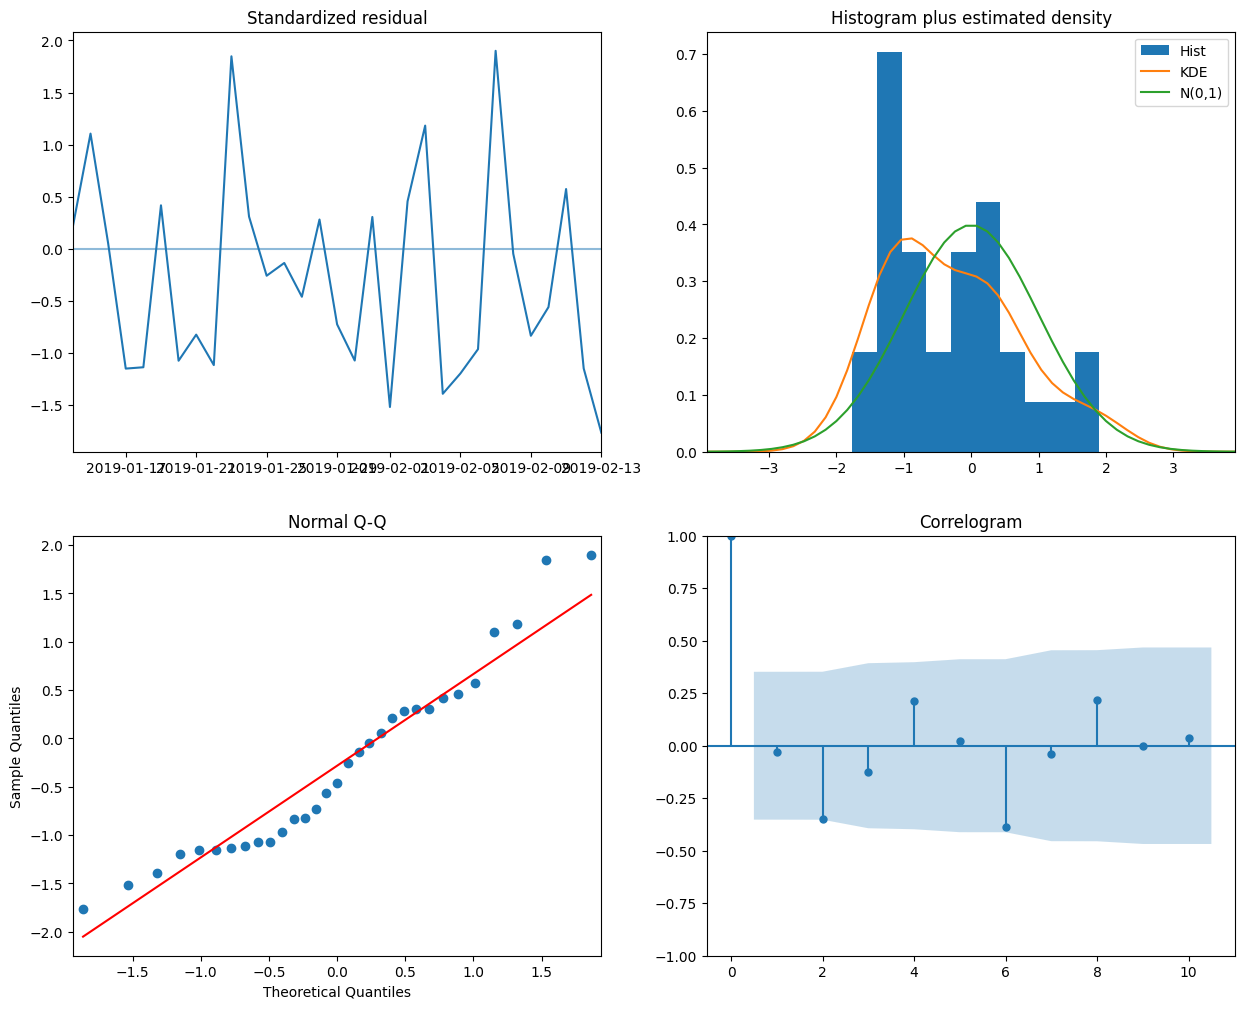

In [123]:
SARIMA_model.plot_diagnostics(figsize=(15, 12))
plt.show()
# import plotly.express as px
# residuals = SARIMA_model.resid()
# fig = px.histogram(residuals, nbins=50, labels={'value':'Residuals'})
# fig.show()

## Plot


In [124]:
def forecast(ARIMA_model, train_data, test_data, periods=24):
    # Forecast
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(
        train_data.index[-1] + pd.DateOffset(days=1), periods=n_periods, freq="D"
    )

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # # Plot
    # plt.figure(figsize=(15, 7))
    # plt.plot(train_data, color="#1f76b4")
    # plt.plot(test_data, color="orange")
    # plt.plot(fitted_series, color="darkgreen")
    # plt.fill_between(
    #     lower_series.index, lower_series, upper_series, color="k", alpha=0.15
    # )

    # plt.title("ARIMA/SARIMA - Forecast of Daily Sales")
    # plt.show()

    import plotly.graph_objects as go

    # Criar um objeto de figura
    fig = go.Figure()

    # Adicionar as séries de treinamento, teste e previsão ao gráfico
    fig.add_trace(
        go.Scatter(
            x=train_data.index,
            y=train_data,
            mode="lines",
            name="Train Data",
            line=dict(color="#1f76b4"),
        )
    )
    fig.add_trace(
        go.Scatter(
            x=test_data.index,
            y=test_data,
            mode="lines",
            name="Test Data",
            line=dict(color="orange"),
        )
    )
    fig.add_trace(
        go.Scatter(
            x=fitted_series.index,
            y=fitted_series,
            mode="lines",
            name="Forecast",
            line=dict(color="darkgreen"),
        )
    )

    # Adicionar o intervalo de confiança ao gráfico
    fig.add_trace(
        go.Scatter(
            x=lower_series.index,
            y=lower_series,
            mode="lines",
            name="Lower Confidence Interval",
            line=dict(color="gray"),
        )
    )
    fig.add_trace(
        go.Scatter(
            x=upper_series.index,
            y=upper_series,
            mode="lines",
            name="Upper Confidence Interval",
            line=dict(color="gray"),
        )
    )

    # Adicionar título e rótulos de eixo
    fig.update_layout(
        title="ARIMA/SARIMA - Forecast of Daily Sales",
        xaxis_title="Date",
        yaxis_title="Sales",
    )

    # Mostrar o gráfico
    fig.show()

In [125]:
forecast(SARIMA_model, train_data, test_data, periods=24*2)